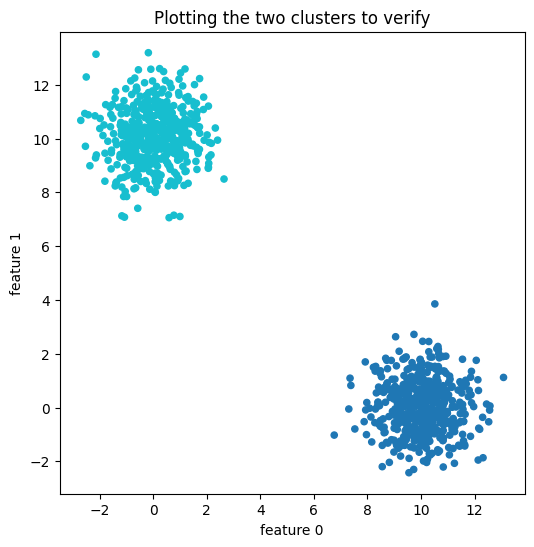

False

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples = [500, 500],
    centers = [(10, 0), (0, 10)],
    n_features = 2,
    random_state = 42,
    cluster_std = 1.0
)

plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=20)
plt.title("Plotting the two clusters to verify")
plt.xlabel("feature 0")
plt.ylabel("feature 1")
plt.show()

In [3]:
### PLOT HELPER FUNCTIONS ###

import numpy as np

def _detect_polarity(scores, y_pred):
    """Return True if larger score means more anomalous (based on means)."""
    mean_in = scores[y_pred == 0].mean() if np.any(y_pred == 0) else np.nan
    mean_out = scores[y_pred == 1].mean() if np.any(y_pred == 1) else np.nan
    return np.isnan(mean_out) or (mean_out > mean_in)

def prepare_scores(model, X_test, res=300, pad=1.0):
    """
    Compute normalized grid and point anomaly scores for plotting.
    Returns: XX, YY, grid_norm (2D), point_norm (1D), y_pred (1D)
    """
    y_pred = model.predict(X_test)
    test_scores = model.decision_function(X_test)
    larger_means_anomalous = _detect_polarity(test_scores, y_pred)
    raw_points = test_scores if larger_means_anomalous else -test_scores

    x_min, x_max = X_test[:, 0].min() - pad, X_test[:, 0].max() + pad
    y_min, y_max = X_test[:, 1].min() - pad, X_test[:, 1].max() + pad
    xx = np.linspace(x_min, x_max, res)
    yy = np.linspace(y_min, y_max, res)
    XX, YY = np.meshgrid(xx, yy)
    grid = np.c_[XX.ravel(), YY.ravel()]

    grid_scores = model.decision_function(grid)
    grid_raw = grid_scores if larger_means_anomalous else -grid_scores

    global_min = min(raw_points.min(), grid_raw.min())
    global_max = max(raw_points.max(), grid_raw.max())
    eps = 1e-12
    grid_norm = (grid_raw - global_min) / (global_max - global_min + eps)
    point_norm = (raw_points - global_min) / (global_max - global_min + eps)

    return XX, YY, grid_norm.reshape(XX.shape), point_norm, y_pred

def plot_decision_surface(XX, YY, grid_norm, X_test, point_norm, y_pred=None,
                          cmap_grid='coolwarm', cmap_points='viridis',
                          title='Decision surface', show_outliers=True, ax=None):
    """
    Plot contour heatmap and scatter of points colored by normalized score.
    Optionally highlights predicted outliers (y_pred == 1).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))
    else:
        fig = ax.figure

    cf = ax.contourf(XX, YY, grid_norm, levels=100, cmap=cmap_grid, alpha=0.6)
    sc = ax.scatter(X_test[:, 0], X_test[:, 1], c=point_norm, cmap=cmap_points,
                    s=25, edgecolors='k', linewidth=0.3)
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label('normalized anomaly score (1 = most anomalous)')

    ax.set_title(title)
    ax.set_xlabel('feature 0')
    ax.set_ylabel('feature 1')
    return fig, ax

(<Figure size 700x600 with 2 Axes>,
 <Axes: title={'center': 'IsolationForest'}, xlabel='feature 0', ylabel='feature 1'>)

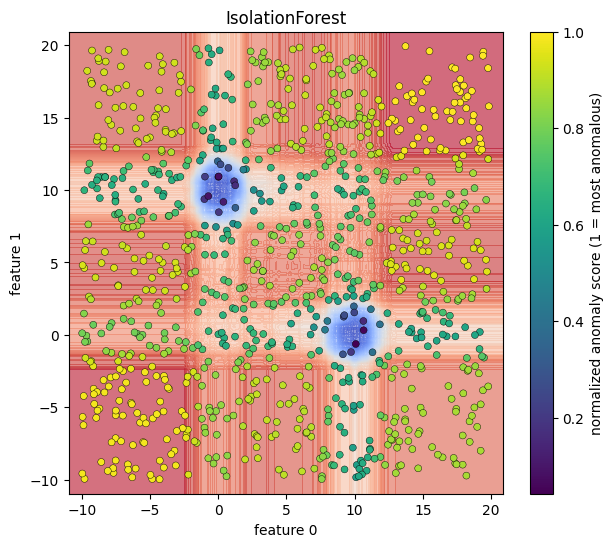

In [4]:
from pyod.models.iforest import IForest

contamination = 0.2
iforest_model = IForest(contamination = contamination, random_state = 42)
iforest_model.fit(X)

X_test = np.random.uniform(low = -10, high = 20, size = (1000,2))
y_test_pred_iforest = iforest_model.predict(X_test)
test_scores_iforest = iforest_model.decision_function(X_test)


XX, YY, grid_norm, point_norm, y_pred = prepare_scores(iforest_model, X_test, res=300, pad=1.0)
plot_decision_surface(XX, YY, grid_norm, X_test, point_norm, y_pred, title='IsolationForest')


c:\Users\2002s\anaconda3\envs\AD\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\2002s\anaconda3\envs\AD\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\2002s\anaconda3\envs\AD\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\2002s\anaconda3\envs\AD\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\2002s\anaconda3\envs\AD\Lib\site-packages\torch\utils\data\

(<Figure size 700x600 with 2 Axes>,
 <Axes: title={'center': 'DIF'}, xlabel='feature 0', ylabel='feature 1'>)

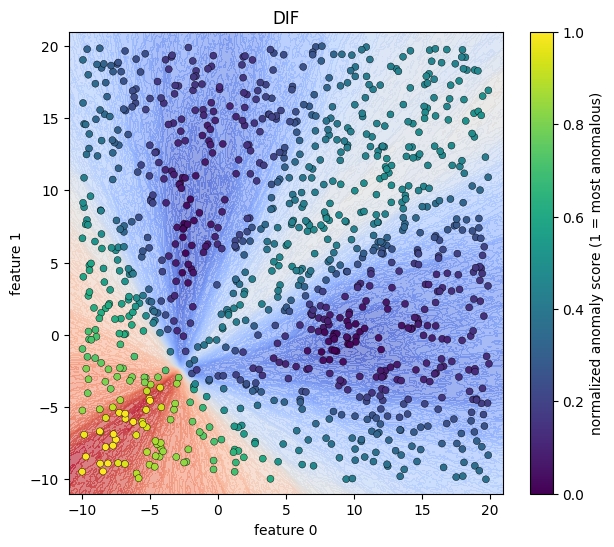

In [5]:
from pyod.models.dif import DIF
from pyod.models.loda import LODA


dif_model = DIF(contamination = contamination, random_state = 42)
dif_model.fit(X)

X_test = np.random.uniform(low = -10, high = 20, size = (1000,2))
y_test_pred_dif = dif_model.predict(X_test)
test_scores_dif = dif_model.decision_function(X_test)


XX, YY, grid_norm, point_norm, y_pred = prepare_scores(dif_model, X_test, res=300, pad=1.0)
plot_decision_surface(XX, YY, grid_norm, X_test, point_norm, y_pred, title='DIF')

(<Figure size 700x600 with 2 Axes>,
 <Axes: title={'center': 'LODA'}, xlabel='feature 0', ylabel='feature 1'>)

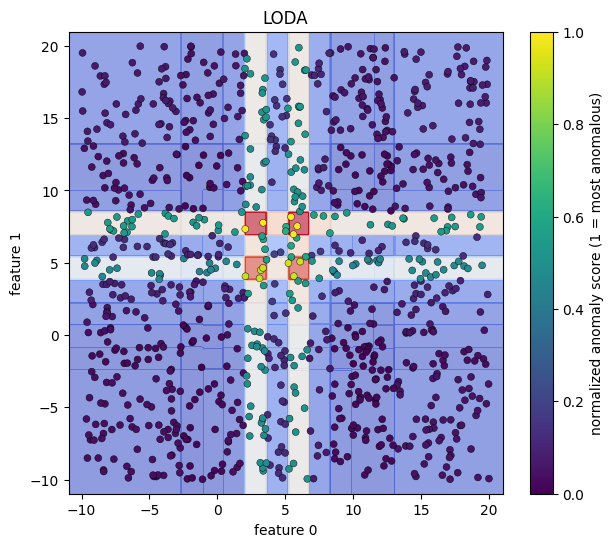

In [7]:
loda_model = LODA(contamination = contamination)
loda_model.fit(X)

X_test = np.random.uniform(low = -10, high = 20, size = (1000,2))
y_test_pred_loda = loda_model.predict(X_test)
test_scores_loda = loda_model.decision_function(X_test)


XX, YY, grid_norm, point_norm, y_pred = prepare_scores(loda_model, X_test, res=300, pad=1.0)
plot_decision_surface(XX, YY, grid_norm, X_test, point_norm, y_pred, title='LODA')